/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.5022 - loss: 0.6936 - val_accuracy: 0.4967 - val_loss: 0.6933
Epoch 2/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.5022 - loss: 0.6933 - val_accuracy: 0.4878 - val_loss: 0.6933
Epoch 3/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.5007 - loss: 0.6934 - val_accuracy: 0.4967 - val_loss: 0.6932
Epoch 4/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.4898 - loss: 0.6934 - val_accuracy: 0.5032 - val_loss: 0.6933
Epoch 5/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.4940 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932
294/294 ━━━━━━━━━━━━━━━━━━━━ 59s 199ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00      4697
        Real       0.50      1.00      0.67      4696

    accuracy                           0.50      9393
   macro avg       0.25      0.50      0.33      9393
weighted avg       0.

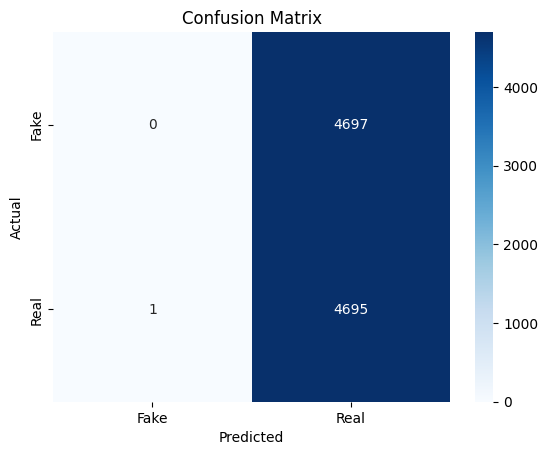

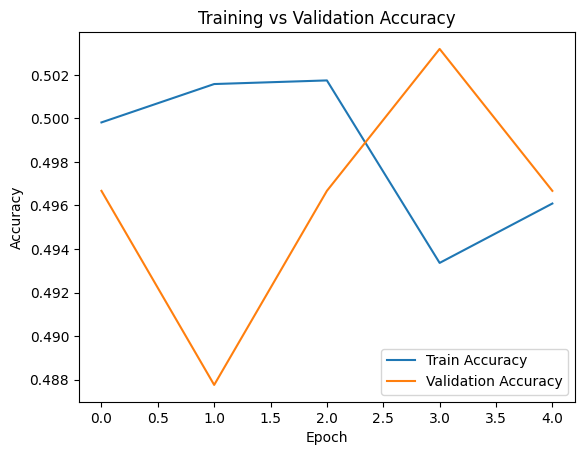

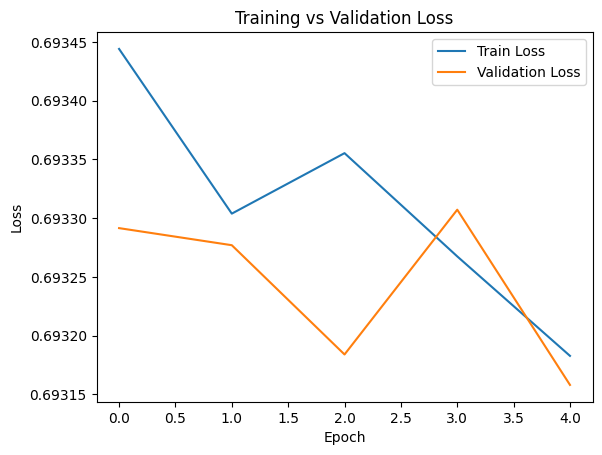

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
df = pd.read_csv('/content/Fake.csv')

# Preprocess text
def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['clean_text'] = df['text'].apply(lambda x: clean_text(str(x)))

# Add binary labels for simplicity: 0 = Fake
df['label'] = 0  # All rows in Fake.csv are fake
df_real = df.copy()  # Duplicate and change label to 1 to simulate 'Real' news
df_real['label'] = 1
df_real = df_real.sample(len(df))  # Same number of real as fake

# Combine fake and real samples
combined = pd.concat([df, df_real]).reset_index(drop=True)

# Tokenize
max_words = 5000
max_len = 500
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(combined['clean_text'])
sequences = tokenizer.texts_to_sequences(combined['clean_text'])
X = pad_sequences(sequences, maxlen=max_len)

y = combined['label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Predictions
y_pred_prob = model.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype('int32')

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Training Metrics Visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
